<a href="https://colab.research.google.com/github/Cairo-Henrique/Estrutura-e-dinamica-de-redes-complexas/blob/main/Rumor_Spreading_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rumor Spreading on Complex Networks

This notebook explores the Maki–Thompson (MT) rumor-spreading model and a modified version with forgetting. The simulations use the Gillespie algorithm in continuous time, applied to complex networks generated with NetworkX.

## Table of Contents

1. [Introduction](#introduction)
2. [Packages](#packages)
3. [Rumor-Spreading Model](#rumor-spreading-model)
4. [Gillespie Simulation Functions](#gillespie-simulation-functions)
5. [Network Creation](#network-creation)
6. [Basic MT Simulation](#basic-mt-simulation)
7. [Modified MT Model](#modified-mt-model)
8. [Analysis and Visualization](#analysis-and-visualization)

## Introduction

Rumor-spreading models describe how information propagates through a population. In the classical Maki–Thompson model, each individual can be:

* *Ignorant* (has not heard the rumor)
* *Spreader* (actively transmits the rumor)
* *Stifler* (knows the rumor but no longer spreads it)

Network structure strongly affects the dynamics, making complex networks a natural setting for simulation.

## Packages

The following Python packages are used:

* `networkx`
* `matplotlib`
* `numpy`

## Rumor-Spreading Model

The MT model is governed by the following interactions:

* *Ignorant + Spreader → Spreader* (rate λ)
* *Spreader + Spreader → Stifler* (rate α)
* *Spreader + Stifler → Stifler* (rate α)

In the modified model, a forgetting mechanism is added:

* *Stifler → Ignorant* (rate δ)

## Gillespie Simulation Functions

We implement the MT and modified MT models using the Gillespie algorithm, constructing all possible events at each step and sampling the next event in continuous time.

## Basic MT Simulation

The classical MT model without forgetting (δ = 0) is simulated to obtain the time evolution of:

* Ignorants
* Spreaders
* Stiflers

## Modified MT Model

When δ > 0, stiflers can forget the rumor and become ignorants again, adding a feedback loop to the dynamics. This produces richer long-term behavior compared to the classical model.

## References:

FERRAZ DE ARRUDA, G.; JEUB, L. G. S.; MATA, A. S. et al. From subcritical behavior to a correlation-induced transition in rumor models. Nature Communications, v. 13, p. 3049, 2022. DOI: 10.1038/s41467-022-30683-z.

Libraries

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

Network creation

In [86]:
# Parâmetros da rede

m = 2000 # number of edges
n = 1000 # number of nodes

In [95]:
# Random directed graph

G = nx.gnm_random_graph(n, m, directed=True)

In [88]:
# Barabási-Albert

new_edges = int(m/n)
G0 = nx.barabasi_albert_graph(n, new_edges)
G = G0.to_directed()

In [89]:
# Watts-Strogatz (small-world)

k = 10
p = 0.1
G0 = nx.watts_strogatz_graph(n, k, p)
G = G0.to_directed()

In [90]:
# Network with 3 communities

sizes = [300, 300, 400]
p = [
    [0.01, 0.005, 0.002],
    [0.005, 0.02, 0.004],
    [0.002, 0.004, 0.015]
]
G = nx.stochastic_block_model(sizes, p, directed=True)

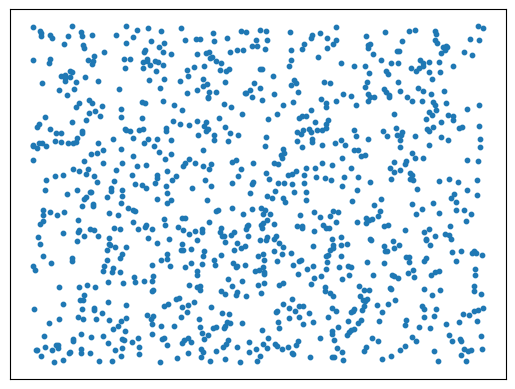

In [91]:
pos = nx.random_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10)
plt.show()

Model

X: ignorant

Y: spreader

Z: stifler

state = (X, Y, Z)



![image.png](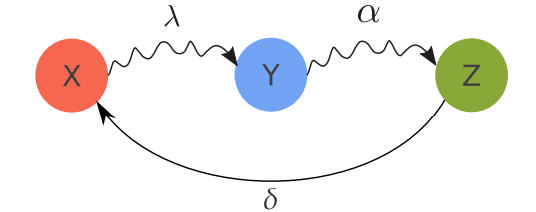

Functions

In [92]:
def add_rumor(G):
    # Selects a random node as a spreader 'y' and adds the attribute ignorant 'x' to the rest
    nx.set_node_attributes(G, 'x', 'state')
    node = np.random.choice(G.nodes())
    G.nodes[node]['state'] = 'y'
    return G

def modified_MT_rumor(G, tmax, lambida, alfa, delta):

    G = add_rumor(G)
    n = len(G.nodes())

    # Time series
    t = [0]
    x = [n-1]
    y = [1]
    z = [0]

    active_spread = set()
    active_stifle = set()
    active_forget = set()

    # initialize active sets
    for u in G.nodes():
        state = G.nodes[u]['state']

        if state == 'y': # spreader
            for v in G.successors(u):
                if G.nodes[v]['state'] == 'x':
                    active_spread.add(v)
                elif G.nodes[v]['state'] == 'y' or G.nodes[v]['state'] == 'z':
                    active_stifle.add(u)
            for v in G.predecessors(u):
                if G.nodes[v]['state'] == 'x':
                    active_spread.add(v)

        elif state == 'z': # stifler
            active_forget.add(u)

    # Main simulation loop
    while t[-1] <= tmax:

        # Create events from active sets
        events = []
        for v in active_spread:
            events.append(("spread", v, lambida))
        for u in active_stifle:
            events.append(("stifling", u, alfa))
        for u in active_forget:
            events.append(("forget", u, delta))

        rates = np.array([ev[2] for ev in events])
        sum_rates = rates.sum()

        if sum_rates == 0:
          break  # processo terminou

        tau = np.random.exponential(scale=1/sum_rates)
        t.append(t[-1] + tau)

        idx = np.random.choice(len(events), p=rates / sum_rates)
        eventtype, node, _ = events[idx]

        # Execute chosen event

        if eventtype == "spread":
            # x → y
            G.nodes[node]['state'] = 'y'

            # Time series update
            x.append(x[-1] - 1)
            y.append(y[-1] + 1)
            z.append(z[-1])

            active_spread.discard(node)     # no longer ignorant
            # node may now produce events:
            for v in G.successors(node):
                if G.nodes[v]['state'] == 'y':
                    active_stifle.add(node)
                elif G.nodes[v]['state'] == 'x':
                    active_spread.add(v)
            for v in G.predecessors(node):
                if G.nodes[v]['state'] == 'x':
                    active_spread.add(v)

        elif eventtype == "stifling":
            # y → z
            G.nodes[node]['state'] = 'z'

            x.append(x[-1])
            y.append(y[-1] - 1)
            z.append(z[-1] + 1)

            active_stifle.discard(node)
            active_spread.discard(node)
            active_forget.add(node)

        else:  # forget
            # z → x
            G.nodes[node]['state'] = 'x'

            x.append(x[-1] + 1)
            y.append(y[-1])
            z.append(z[-1] - 1)

            active_forget.discard(node)
            active_spread.discard(node)
            active_stifle.discard(node)

    # Convert to fractions
    x = np.array(x) / n
    y = np.array(y) / n
    z = np.array(z) / n

    return t, x, y, z

Parameters

In [93]:
# Parâmetros da propagação

lambida = 1 # rate of ignorant becoming spreader in spreader -> ignorant contact
alfa = 0.5 # rate of spreader becoming stifler in spreader -> spreader or stifler contact
delta = 0.5 # rate of stifler becoming ignorant spontaneously (forgetting mechanism)
tmax = 100 # maximum time

Results

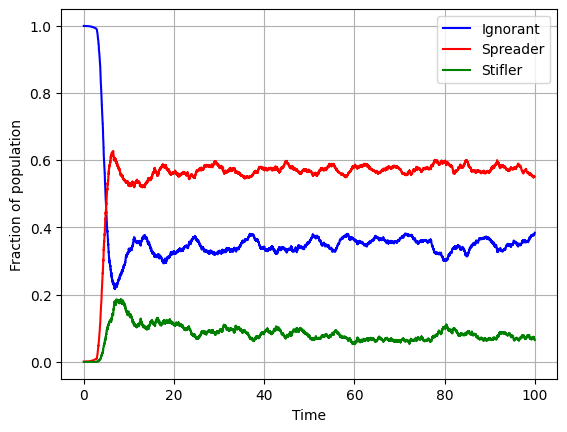

In [96]:
t, x, y, z = modified_MT_rumor(G, tmax, lambida, alfa, delta)

# Gráfico
plt.figure()
plt.plot(t, x, label='Ignorant', color='blue')
plt.plot(t, y, label='Spreader', color='red')
plt.plot(t, z, label='Stifler', color='green')
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.show()